# Vocabulary analysis
In this notebooks, I'll look for out-of-vocabulary words in each pairwise comparison of corpora. The more out-of-vocabulary words for a given pair, the less similar they are to one another. We expect that SciERC and PICKLE will have more overlapping vocabulary.

In [8]:
import json
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import pandas as pd
import numpy as np

# Importing my own Dataset class
import sys
sys.path.append('../models/corpus_comparison/')
from dataset import Dataset

For this analysis, we'll use the SciERC, GENIA, ChemProt, SeeDev and PICKLE corpora to get the sets of tokens that make up the three corpora. We'll then look for the fraction of PICKLE's vocabulary that doesn't appear in the vocabulary of each of the comparison datasets (i.e. is out-of-vocabulary for a given dataset). Based on the pre-trained model results, in which SciERC outperformed all other models on the PICKLE corpus, we expect to see that there are more out-of-vocabulary words for the GENIA, ChemProt, and SeeDev-PICKLE comparisons than in the SciERC-PICKLE comparison.
### Getting corpus vocabularies

#### Downloading SciERC and GENIA data
We'll use the code provided in the [DyGIE++](https://github.com/dwadden/dygiepp) repo for this purpose, as well as our processed version of SeeDev, running the following commands from the root of the `dygiepp` repo:

```
bash ./scripts/data/get_scierc.sh
```

```
bash ./scripts/data/get_genia.sh
```

```
bash ./scripts/data/get_chemprot.sh
```

### Comparing vocabularies
Now that we have all the datasets, we can compare them. This is done with the script `out_of_vocab_comparison.py`, found in the `models/OOV_comparison` directory.


*A summary of the comparisons:* For each pair of datasets, a total of 3 metrics were calculated. For each of unigrams, bigrams, and trigrams, the following calculation was computed:

```len(set(ngrams in PICKLE) - set(ngrams in GENIA/SciERC)) / len(ngrams in PICKLE)```

#### Looking at comparison outputs
Now, lets read in the data and see what the situation is.

In [15]:
path_prefix = '../data/straying_off_topic_data/corpus_comparison/'
frac_paths = {
    'pickle_vs_genia': 'genia_vs_pickle_16Aug2023_fracs.json',
    'pickle_vs_seedev': 'seedev_vs_pickle_16Aug2023_fracs.json',
    'pickle_vs_chemprot': 'chemprot_vs_pickle_16Aug2023_fracs.json',
    'pickle_vs_scierc': 'scierc_vs_pickle_16Aug2023_fracs.json'
}

In [16]:
fracs = {}
for comp_name, fname in frac_paths.items():
    with open(f'{path_prefix}{fname}') as myf:
        frac = json.load(myf)
    fracs[comp_name] = frac

In [18]:
fracs

{'pickle_vs_genia': {'unigrams': 0.5206918849013903,
  'bigrams': 0.6998304126625212,
  'trigrams': 0.8751560895746039},
 'pickle_vs_seedev': {'unigrams': 0.7573553184610411,
  'bigrams': 0.9052733586368408,
  'trigrams': 0.9708632794072759},
 'pickle_vs_chemprot': {'unigrams': 0.45263498221791143,
  'bigrams': 0.7039489622870064,
  'trigrams': 0.8895024558093071},
 'pickle_vs_scierc': {'unigrams': 0.7386032977691561,
  'bigrams': 0.915327465073084,
  'trigrams': 0.979826289646752}}

In [26]:
# Convert to proportion in-vocab to be more intuitive
for comp in fracs.keys():
    for gram_len in fracs[comp].keys():
        fracs[comp][gram_len] = 1 - fracs[comp][gram_len]

To better visualize the situation, let's make a bar plot!

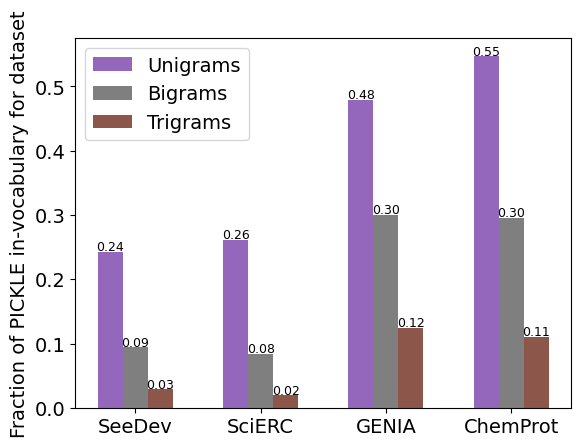

In [30]:
label_map = {
    'pickle_vs_seedev': 'SeeDev',
    'pickle_vs_scierc': 'SciERC',
    'pickle_vs_genia': 'GENIA',
    'pickle_vs_chemprot': 'ChemProt'
}
xlabs = list(label_map.values())
unigrams = [fracs[lab]['unigrams'] for lab in label_map.keys()]
bigrams = [fracs[lab]['bigrams'] for lab in label_map.keys()]
trigrams = [fracs[lab]['trigrams'] for lab in label_map.keys()]

x = np.arange(len(xlabs))
x = 0.5*x
width = 0.1

fig, ax = plt.subplots()
ax.bar(x - width, unigrams, width, color='tab:purple', label='Unigrams')
ax.bar(x, bigrams, width, color='tab:grey', label='Bigrams')
ax.bar(x + width, trigrams, width, color='tab:brown', label='Trigrams')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
               (bar.get_x() + bar.get_width() / 2,
               bar.get_height()), ha='center', va='top',
               size=9, xytext=(0,8),
               textcoords='offset points')

plt.ylabel('Fraction of PICKLE in-vocabulary for dataset')
plt.xticks(x, xlabs)
plt.legend(loc='upper left')

plt.savefig('../data/straying_off_topic_data/corpus_comparison/figures/oov_plot.png', bbox_inches='tight', dpi=300)

This corresponds to what we would have expected to see originally -- that GENIA and ChemProt have better coverage of PICKLE's vocabulary than SciERC and SeeDev. We expect that of SeeDev because it's small, even though its topic is better aligned.